# Time Series End-to-End Exercise
***

## Forecasting Tokyo Temperatures

The goal of this mini-project is to predict Tokyo temperatures over the next year (Oct 2013 - Sep 2014), month by month. Since this prediction is not too far in the future, I will be using recent data (Oct 2008 - Sep 2013).

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings('ignore')

### Acquire Data

The data was acquired from https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data and saved as a .csv.

In [2]:
temps = pd.read_csv('GlobalLandTemperaturesByCity.csv')

In [3]:
temps.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [4]:
temps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [5]:
#Grab only the tokyo data
tokyo = temps[temps.City == 'Tokyo']

In [6]:
#Save the tokyo data as a .csv for easy access later
tokyo.to_csv('tokyo_temps.csv')

In [7]:
tokyo.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
7659221,1845-01-01,2.377,2.006,Tokyo,Japan,36.17N,139.23E
7659222,1845-02-01,1.312,2.968,Tokyo,Japan,36.17N,139.23E
7659223,1845-03-01,5.276,1.506,Tokyo,Japan,36.17N,139.23E
7659224,1845-04-01,10.387,1.508,Tokyo,Japan,36.17N,139.23E
7659225,1845-05-01,14.923,1.448,Tokyo,Japan,36.17N,139.23E


In [8]:
tokyo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2025 entries, 7659221 to 7661245
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2025 non-null   object 
 1   AverageTemperature             2020 non-null   float64
 2   AverageTemperatureUncertainty  2020 non-null   float64
 3   City                           2025 non-null   object 
 4   Country                        2025 non-null   object 
 5   Latitude                       2025 non-null   object 
 6   Longitude                      2025 non-null   object 
dtypes: float64(2), object(5)
memory usage: 126.6+ KB


### Prepare Data

In [9]:
#Are there any nulls I need to worry about?
tokyo.isnull().sum()

dt                               0
AverageTemperature               5
AverageTemperatureUncertainty    5
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

There are 5 null values in the 'AverageTemperature' and 'AverageTemperatureUncertainty' columns. Since there are only 5, and I don't want any null or missing values in my dataset, I will simply use the previous values to fill them in.

In [10]:
#Convert date to datetime object
tokyo['dt'] = pd.to_datetime(tokyo['dt'])

In [11]:
#Take a look at the null values
tokyo[pd.isnull(tokyo.AverageTemperature)]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
7659521,1870-01-01,NaN,NaN,Tokyo,Japan,36.17N,139.23E
7659522,1870-02-01,NaN,NaN,Tokyo,Japan,36.17N,139.23E
7659523,1870-03-01,NaN,NaN,Tokyo,Japan,36.17N,139.23E
7659524,1870-04-01,NaN,NaN,Tokyo,Japan,36.17N,139.23E
7661245,2013-09-01,NaN,NaN,Tokyo,Japan,36.17N,139.23E


In [12]:
#Fill in the missing values with the previous values
tokyo.fillna(method = 'pad', inplace = True)

In [13]:
tokyo.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

In [14]:
#Make the date the index and sort
tokyo = tokyo.set_index('dt').sort_index()

In [15]:
#Now convert celsius to farenheit
tokyo.AverageTemperature = round((tokyo.AverageTemperature * 1.8) + 32)
tokyo.AverageTemperatureUncertainty = round((tokyo.AverageTemperatureUncertainty * 1.8) + 32)

In [16]:
tokyo.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1845-01-01,36.0,36.0,Tokyo,Japan,36.17N,139.23E
1845-02-01,34.0,37.0,Tokyo,Japan,36.17N,139.23E
1845-03-01,41.0,35.0,Tokyo,Japan,36.17N,139.23E
1845-04-01,51.0,35.0,Tokyo,Japan,36.17N,139.23E
1845-05-01,59.0,35.0,Tokyo,Japan,36.17N,139.23E


In [17]:
#Drop all columns except AverageTemperature
tokyo = tokyo.drop(columns = ['AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude'])

In [18]:
#Now split into train, validate, and test sets
train = tokyo['2008-10':'2011-09']
train.shape

(36, 1)

In [19]:
validate = tokyo['2011-10':'2012-09']
validate.shape

(12, 1)

In [20]:
test = tokyo['2012-10':'2013-09']
test.shape

(12, 1)

### Explore Data

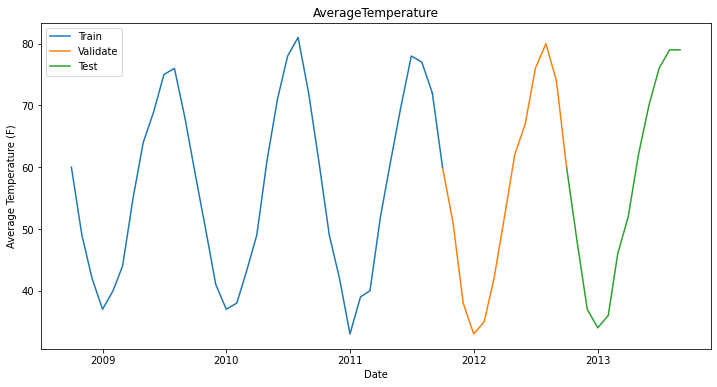

In [21]:
#Plot the data
plt.figure(figsize=(12,6))
plt.plot(train['AverageTemperature'], label = 'Train', color = '#1f77b4')
plt.plot(validate['AverageTemperature'], label = 'Validate', color = '#ff7f0e')
plt.plot(test['AverageTemperature'], label = 'Test', color = '#2ca02c')
plt.plot(tokyo['2011-09':'2011-10']['AverageTemperature'], color = '#1f77b4')
plt.plot(tokyo['2012-09':'2012-10']['AverageTemperature'], color = '#ff7f0e')
plt.title('AverageTemperature')
plt.xlabel('Date')
plt.ylabel('Average Temperature (F)')
plt.legend()
plt.show()

As expected there is an apparent cycle from year to year. I think using the previous cycle method to make predictions will be a good option.

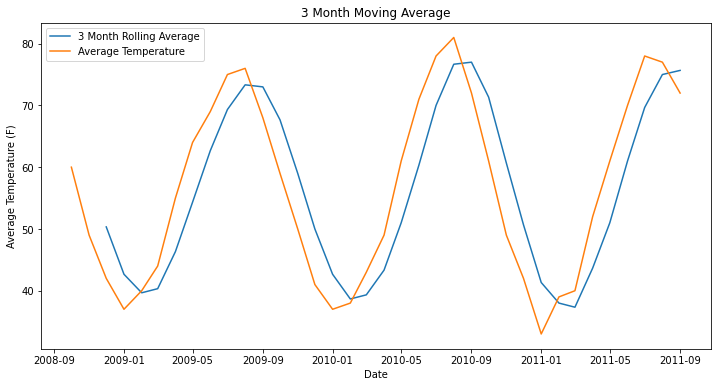

In [22]:
plt.figure(figsize=(12,6))
plt.plot(train['AverageTemperature'].rolling(3).mean(), label = '3 Month Rolling Average')
plt.plot(train['AverageTemperature'], label = 'Average Temperature')
plt.title('3 Month Moving Average')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average Temperature (F)')
plt.show()

In [23]:
result = sm.tsa.seasonal_decompose(train.AverageTemperature)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})

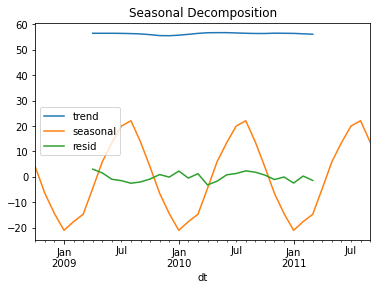

In [24]:
decomposition.iloc[:, 1:].plot()
plt.title('Seasonal Decomposition')
plt.show()

### Model Data

Some helpful functions:

In [25]:
def evaluate(target_var):
    """
        This function will calculate the RMSE and return it.
    """
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [26]:
def plot_and_eval(target_var):
    """
        This function will use the evaluate function and also plot train 
        and test values with the predicted values in order to compare performance.
    """
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'Prediction', linewidth = 1)
    plt.title(target_var)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Average Temperate (F)')
    plt.plot(tokyo['2011-09':'2011-10']['AverageTemperature'], color = '#1f77b4', linewidth = 1)
    plt.plot(tokyo['2012-09':'2012-10']['AverageTemperature'], color = '#ff7f0e', linewidth = 1)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [27]:
#Create an evaluation dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    """
        This function will append evaluation metrics for each model type, target variable, 
        and metric type, along with the metric value into our eval_df data frame object. 
    """
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [28]:
def make_predictions():
    yhat_df = pd.DataFrame({'AverageTemperature': [avg_temp],
                           }, index = validate.index)
    return yhat_df

### Simple Average

In [29]:
#Find the average
avg_temp = round(train.AverageTemperature.mean(), 2)

In [30]:
yhat_df = make_predictions()

AverageTemperature -- RMSE: 16


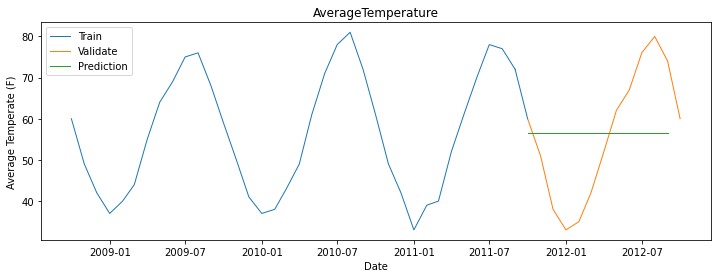

In [31]:
for col in train.columns:
    plot_and_eval(col)

In [32]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [33]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,16.0


### Moving Average

In [34]:
periods = [1, 3, 6, 9, 12]

for p in periods:
    avg_temp = round(train['AverageTemperature'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'm moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'AverageTemperature'
                            )

In [35]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,16.0
1,1m moving average,AverageTemperature,23.0
2,3m moving average,AverageTemperature,25.0
3,6m moving average,AverageTemperature,20.0
4,9m moving average,AverageTemperature,16.0
5,12m moving average,AverageTemperature,16.0


### Holt's Linear Trend

In [36]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .45, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

AverageTemperature -- RMSE: 13


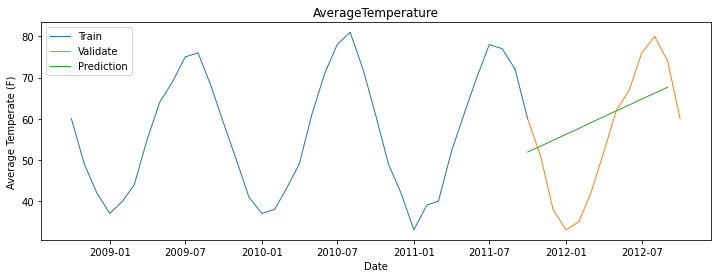

In [37]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [38]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [39]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,16.0
1,1m moving average,AverageTemperature,23.0
2,3m moving average,AverageTemperature,25.0
3,6m moving average,AverageTemperature,20.0
4,9m moving average,AverageTemperature,16.0
5,12m moving average,AverageTemperature,16.0
6,Holts,AverageTemperature,13.0


### Prediction Using Previous Cycle

In [40]:
#Add the average yearly difference to the last year's values in train
yhat_df = train['2010-10':'2011-09'] + train.diff(12).mean()

In [41]:
# set yhat_df to index of validate
yhat_df.index = validate.index

AverageTemperature -- RMSE: 2


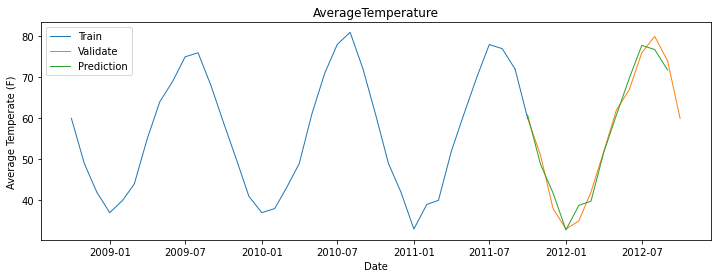

In [42]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [43]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,16.0
1,1m moving average,AverageTemperature,23.0
2,3m moving average,AverageTemperature,25.0
3,6m moving average,AverageTemperature,20.0
4,9m moving average,AverageTemperature,16.0
5,12m moving average,AverageTemperature,16.0
6,Holts,AverageTemperature,13.0
7,previous year,AverageTemperature,2.0


### Evaluate on Test

In [44]:
#Choose best model by finding the lowest rmse
eval_df.sort_values(by = 'rmse', ascending = False).tail(1)

,model_type,target_var,rmse
7,previous year,AverageTemperature,2.0


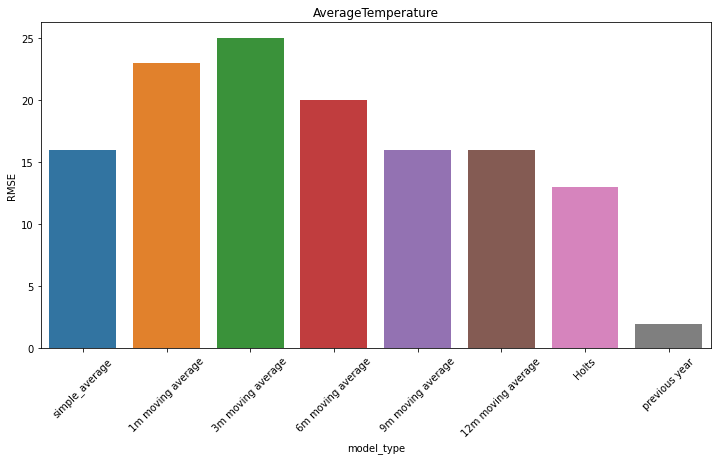

In [45]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

My best model is the previous year model. To evaluate it on test, I will take the average yearly difference from train and add it to the validate set, then apply the test index to those values.

In [46]:
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [47]:
rmse_farenheit = round(sqrt(mean_squared_error(test['AverageTemperature'], yhat_df['AverageTemperature'])), 0)

In [48]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5, label = 'Prediction', color = 'purple')
    plt.plot(tokyo['2011-09':'2011-10']['AverageTemperature'], color = '#1f77b4', linewidth = 1)
    plt.plot(tokyo['2012-09':'2012-10']['AverageTemperature'], color = '#ff7f0e', linewidth = 1)
    plt.title(target_var)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Average Temperate (F)')
    plt.show()

In [49]:
tokyo.tail()

,AverageTemperature
dt,
2013-05-01,62.0
2013-06-01,70.0
2013-07-01,76.0
2013-08-01,79.0
2013-09-01,79.0


rmse - degrees farenheit:  2.0


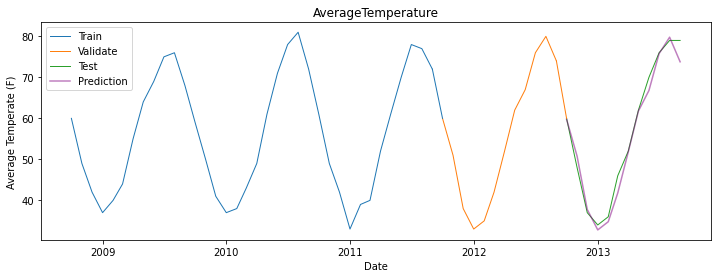

In [50]:
print("rmse - degrees farenheit: ", rmse_farenheit)

for col in train.columns:
    plot_and_eval(col)

### Forecasting The Next Year (Oct 2013 - Sep 2014)

In [51]:
#Create a df with an index of the desired time frame
future_temps = pd.DataFrame()
future_temps['date'] = pd.date_range(start = '2013-10', end = '2014-09', closed = None, freq = 'MS')
future_temps = future_temps.set_index('date').sort_index()

In [52]:
#Now get predictions
yhat_df = test + train.diff(12).mean()

In [53]:
#Set the index to future_temps index
yhat_df = yhat_df.set_index(future_temps.index)

In [54]:
#append this data to the original tokyo dataframe
tokyo = pd.concat([tokyo, yhat_df], axis = 0)

In [55]:
yhat_df

,AverageTemperature
date,
2013-10-01,59.791667
2013-11-01,47.791667
2013-12-01,36.791667
2014-01-01,33.791667
2014-02-01,35.791667
2014-03-01,45.791667
2014-04-01,51.791667
2014-05-01,61.791667
2014-06-01,69.791667


In [56]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5, label = 'Prediction', color = 'purple')
    plt.plot(tokyo['2011-09':'2011-10']['AverageTemperature'], color = '#1f77b4', linewidth = 1)
    plt.plot(tokyo['2012-09':'2012-10']['AverageTemperature'], color = '#ff7f0e', linewidth = 1)
    plt.plot(tokyo['2013-09':'2013-10']['AverageTemperature'], color = '#2ca02c', linewidth = 1)
    plt.title(target_var)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Average Temperate (F)')
    plt.show()

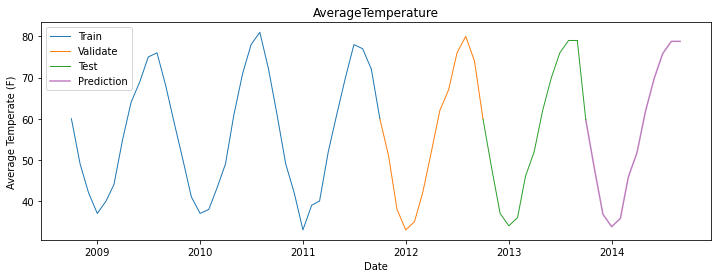

In [57]:
for col in train.columns:
    plot_and_eval(col)